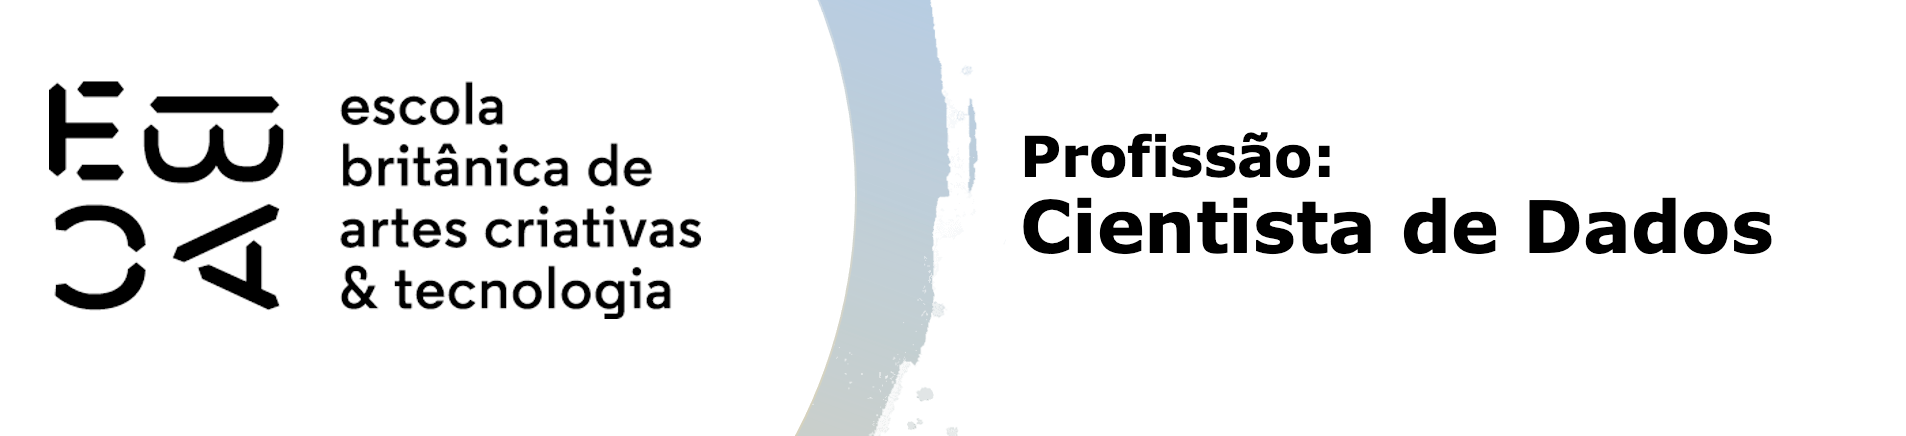

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from pycaret.classification import setup, compare_models, create_model, tune_model, evaluate_model, finalize_model, interpret_model, plot_model, predict_model, save_model, save_experiment

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [2]:
# Ordenando o dataframe pela coluna 'data_ref'
df = df.sort_values(by='data_ref')

# Identificando os três últimos meses únicos
last_three_months = df['data_ref'].unique()[-3:]

# Separando os datasets
train_df = df[~df['data_ref'].isin(last_three_months)]
oot_df = df[df['data_ref'].isin(last_three_months)]

# Excluindo as colunas 'data_ref' e 'index'
train_df = train_df.drop(columns=['data_ref', 'index'])
oot_df = oot_df.drop(columns=['data_ref', 'index'])


In [3]:
# Verificando quais colunas possuem NaN
cols_with_nan = train_df.columns[train_df.isnull().any()].tolist()

print(f"Colunas com NaN: {cols_with_nan}")

# Preenchendo NaN
for col in cols_with_nan:
    # Se a coluna for numérica
    if pd.api.types.is_numeric_dtype(train_df[col]):
        train_df[col].fillna(train_df[col].mean(), inplace=True)
        oot_df[col].fillna(train_df[col].mean(), inplace=True) # Note que estamos usando a média do train_df para preencher o oot_df
    # Se a coluna for categórica
    elif pd.api.types.is_string_dtype(train_df[col]) or pd.api.types.is_categorical_dtype(train_df[col]):
        mode_value = train_df[col].mode()[0]
        train_df[col].fillna(mode_value, inplace=True)
        oot_df[col].fillna(mode_value, inplace=True)


Colunas com NaN: ['tempo_emprego']


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [4]:
print(f"Número de linhas: {df.shape[0]}")
print(f"Número de colunas: {df.shape[1]}")
print(f"Número de linhas: {df.shape[0]}")
print(f"Número de colunas: {df.shape[1]}")

Número de linhas: 750000
Número de colunas: 15
Número de linhas: 750000
Número de colunas: 15


In [5]:
print(df['data_ref'].value_counts())

data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64


In [6]:
qualitative_vars = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'mau']

for var in qualitative_vars:
    print(df[var].value_counts())
    print("\n")

sexo
F    504580
M    245420
Name: count, dtype: int64


posse_de_veiculo
N    457954
S    292046
Name: count, dtype: int64


posse_de_imovel
S    503692
N    246308
Name: count, dtype: int64


tipo_renda
Assalariado         385740
Empresário          172712
Pensionista         126265
Servidor público     64922
Bolsista               361
Name: count, dtype: int64


educacao
Médio                  506836
Superior completo      204306
Superior incompleto     29471
Fundamental              8575
Pós graduação             812
Name: count, dtype: int64


estado_civil
Casado      526472
Solteiro     91659
União        57685
Separado     42571
Viúvo        31613
Name: count, dtype: int64


tipo_residencia
Casa             674294
Com os pais       33232
Governamental     23440
Aluguel           10349
Estúdio            5395
Comunitário        3290
Name: count, dtype: int64


mau
False    691357
True      58643
Name: count, dtype: int64




In [7]:
quantitative_vars = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

print(df[quantitative_vars].describe())

          qtd_filhos          idade  tempo_emprego  qt_pessoas_residencia  \
count  750000.000000  750000.000000  624043.000000          750000.000000   
mean        0.433251      43.804733       7.748574               2.212241   
std         0.739379      11.229868       6.687455               0.903428   
min         0.000000      22.000000       0.117808               1.000000   
25%         0.000000      34.000000       3.049315               2.000000   
50%         0.000000      43.000000       6.046575               2.000000   
75%         1.000000      53.000000      10.183562               3.000000   
max        14.000000      68.000000      42.906849              15.000000   

              renda  
count  7.500000e+05  
mean   2.323854e+04  
std    7.910601e+04  
min    1.076700e+02  
25%    3.467700e+03  
50%    7.861820e+03  
75%    1.831828e+04  
max    4.083986e+06  


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

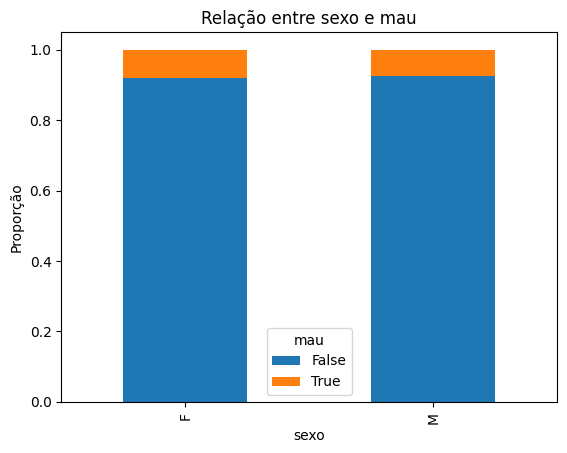

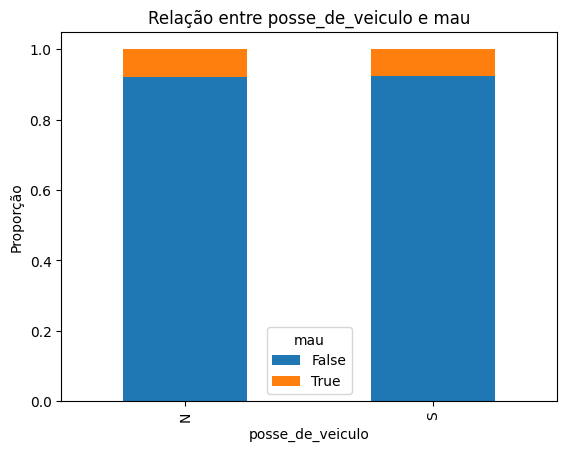

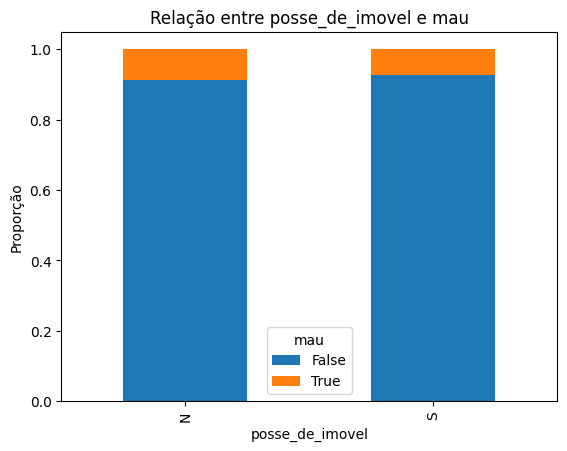

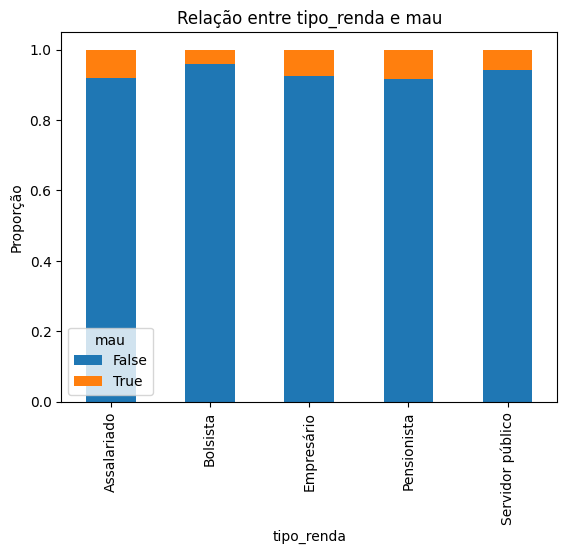

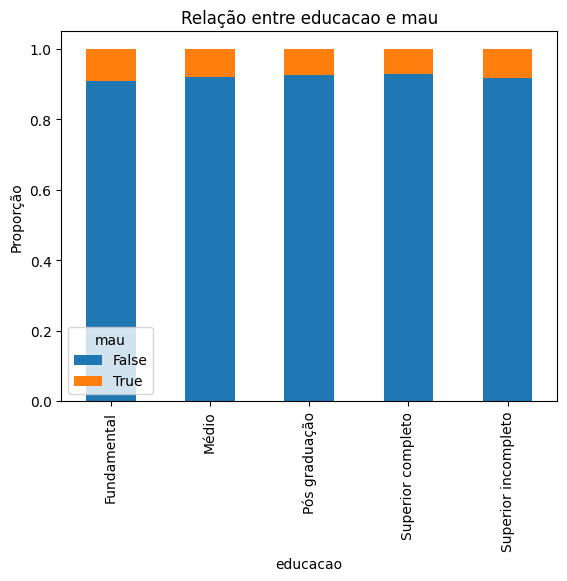

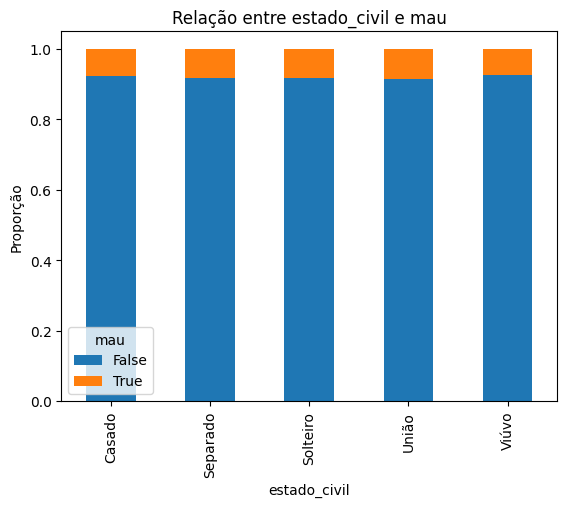

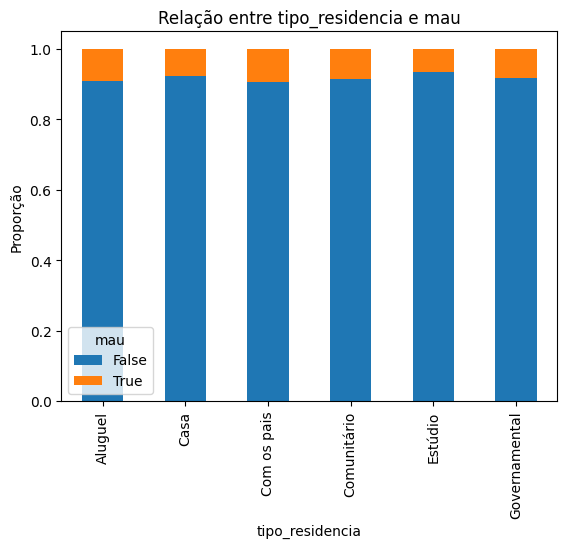

In [8]:
qualitative_vars = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

for var in qualitative_vars:
    ct = pd.crosstab(df[var], df['mau'], normalize='index') # cria uma tabela cruzada
    ct.plot(kind='bar', stacked=True)
    plt.title(f'Relação entre {var} e mau')
    plt.ylabel('Proporção')
    plt.show()


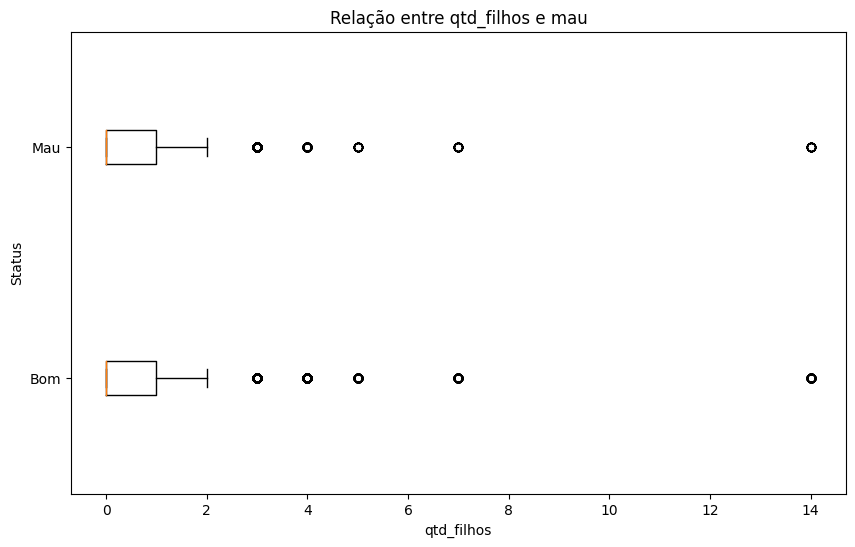

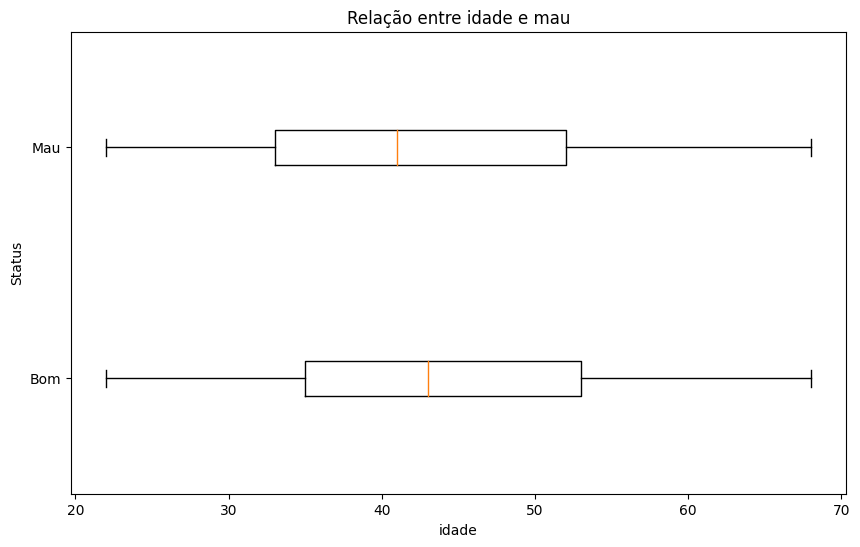

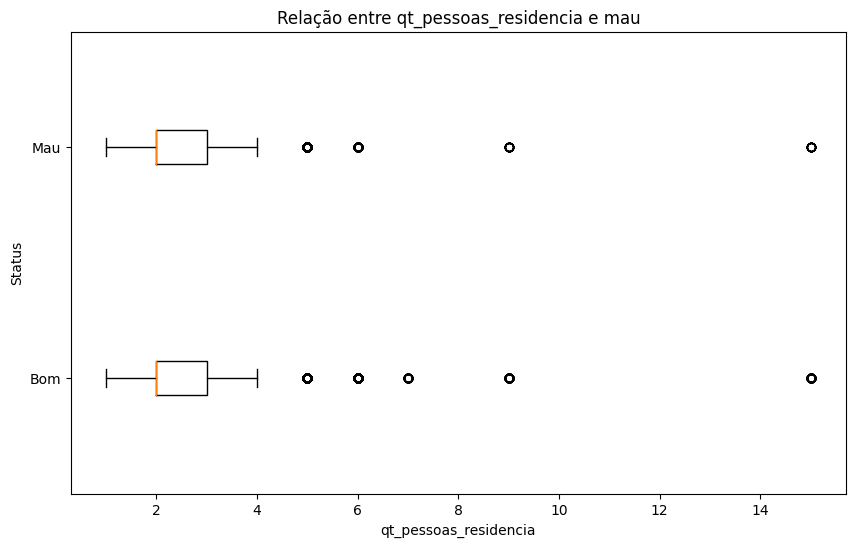

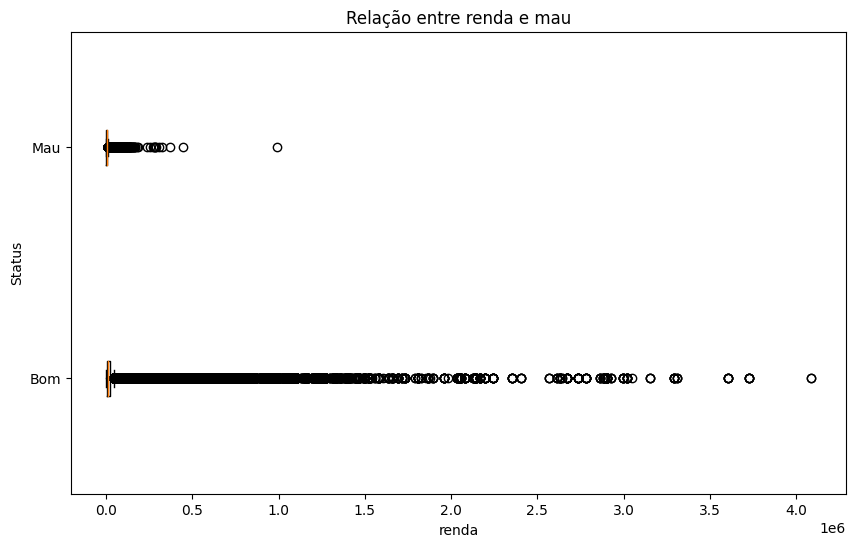

In [9]:
quantitative_vars = ['qtd_filhos', 'idade', 'qt_pessoas_residencia', 'renda']

for var in quantitative_vars:
    plt.figure(figsize=(10,6))
    plt.boxplot([df[df['mau']==False][var], df[df['mau']==True][var]], vert=False, labels=['Bom', 'Mau'])
    plt.title(f'Relação entre {var} e mau')
    plt.xlabel(var)
    plt.ylabel('Status')
    plt.show()


## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [11]:
# Preparando os dados

# Codificando variáveis categóricas
le = LabelEncoder()
for col in train_df.select_dtypes(include=['object']):
    train_df[col] = le.fit_transform(train_df[col])
    oot_df[col] = le.transform(oot_df[col])  # Transformar usando o mesmo encoder

# Separando as variáveis independentes da dependente
X_train = train_df.drop(columns=['mau'])
y_train = train_df['mau']

X_oot = oot_df.drop(columns=['mau'])
y_oot = oot_df['mau']

# Escalando as variáveis
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_oot = scaler.transform(X_oot)  # Usar o mesmo scaler

# Treinando o modelo
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Coeficientes
coef = model.coef_
intercept = model.intercept_

print(f"Intercept: {intercept}")
for feature, coef_ in zip(train_df.drop(columns=['mau']).columns, coef[0]):
    print(f"{feature}: {coef_}")

Intercept: [-4.54499859]
sexo: -0.0580069688886445
posse_de_veiculo: 0.013844804944076226
posse_de_imovel: -0.04223516929793069
qtd_filhos: 0.0006959844289584369
tipo_renda: -0.02160145523199482
educacao: -0.027209700783714676
estado_civil: 0.006221043482981823
tipo_residencia: -0.0003318855981472853
idade: -0.0004483220748916773
tempo_emprego: -0.1444480056518638
qt_pessoas_residencia: 0.002625961702742043
renda: -8.816000414607737


## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [12]:
# Definindo X e y para o conjunto de treinamento
X_train = train_df.drop('mau', axis=1)
y_train = train_df['mau']

# Criando e treinando o modelo de regressão logística
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)


LogisticRegression()

In [13]:
# Fazendo as previsões para as bases de desenvolvimento e de teste (out-of-time)
y_pred_train = logistic_model.predict(train_df.drop('mau', axis=1))
y_pred_prob_train = logistic_model.predict_proba(train_df.drop('mau', axis=1))[:, 1]

y_pred_oot = logistic_model.predict(oot_df.drop('mau', axis=1))
y_pred_prob_oot = logistic_model.predict_proba(oot_df.drop('mau', axis=1))[:, 1]

In [14]:
train_accuracy = accuracy_score(train_df['mau'], y_pred_train)
oot_accuracy = accuracy_score(oot_df['mau'], y_pred_oot)

print(f"Acurácia na base de desenvolvimento: {train_accuracy}")
print(f"Acurácia na base out-of-time: {oot_accuracy}")

Acurácia na base de desenvolvimento: 0.9389283333333334
Acurácia na base out-of-time: 0.8533333333333334


In [15]:
fpr_train, tpr_train, _ = roc_curve(train_df['mau'], y_pred_prob_train)
fpr_oot, tpr_oot, _ = roc_curve(oot_df['mau'], y_pred_prob_oot)

KS_train = np.max(tpr_train - fpr_train)
KS_oot = np.max(tpr_oot - fpr_oot)

print(f"Estatística KS na base de desenvolvimento: {KS_train}")
print(f"Estatística KS na base out-of-time: {KS_oot}")

Estatística KS na base de desenvolvimento: 0.3773939173862029
Estatística KS na base out-of-time: 0.2766171875000001


In [16]:
AUC_train = roc_auc_score(train_df['mau'], y_pred_prob_train)
AUC_oot = roc_auc_score(oot_df['mau'], y_pred_prob_oot)

Gini_train = 2 * AUC_train - 1
Gini_oot = 2 * AUC_oot - 1

print(f"Coeficiente de Gini na base de desenvolvimento: {Gini_train}")
print(f"Coeficiente de Gini na base out-of-time: {Gini_oot}")

Coeficiente de Gini na base de desenvolvimento: 0.501528155991084
Coeficiente de Gini na base out-of-time: 0.3766584907670454


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

In [17]:
# Para variáveis quantitativas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Para variáveis categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']),
        ('cat', categorical_transformer, ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'])])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter=1000))])

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [18]:
# Identificando colunas com NaN
cols_with_nan = train_df.columns[train_df.isnull().any()].tolist()
print(f"Colunas com NaN: {cols_with_nan}")

Colunas com NaN: []


### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [19]:
def remove_outliers(df, columns):
    """
    Remove outliers usando a fórmula do IQR para cada coluna em 'columns'.
    Retorna o DataFrame sem outliers.
    """
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df = df[~((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))]
    return df

# Colunas numéricas onde queremos remover outliers
columns_to_check = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

# Removendo outliers
train_df_no_outliers = remove_outliers(train_df, columns_to_check)

print(f"Tamanho original: {len(train_df)}, Tamanho após remoção de outliers: {len(train_df_no_outliers)}")

Tamanho original: 600000, Tamanho após remoção de outliers: 502136


### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [20]:
# Carregando dados
iris = load_iris()
X = iris.data
y = iris.target

# Treinando o modelo
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X, y)

# Importância de recurso
feature_importance = clf.feature_importances_

# Mostrando importância
for i, score in enumerate(feature_importance):
    print(f"Feature {i}: {score}")

Feature 0: 0.09032488067438549
Feature 1: 0.02642460034826833
Feature 2: 0.4546396202701394
Feature 3: 0.42861089870720687


### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 4

In [21]:
# Carregando dados
iris = load_iris()
X = iris.data
y = iris.target

# Inicializando PCA e o número de componentes para reduzir
pca = PCA(n_components=4)  # Número de componentes ajustado

# Ajustando e transformar os dados
X_pca = pca.fit_transform(X)

# Mostrando o resultado
print("Original shape:", X.shape)
print("Transformed shape:", X_pca.shape)

# Mostrando a variância explicada por cada componente
print("Variância explicada por cada componente:", pca.explained_variance_ratio_)

Original shape: (150, 4)
Transformed shape: (150, 4)
Variância explicada por cada componente: [0.92461872 0.05306648 0.01710261 0.00521218]


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [22]:
# Dados
data = {
    'sexo': ['M', 'F', 'M', 'F'],
    'posse_de_veiculo': ['Y', 'N', 'Y', 'N'],
    'posse_de_imovel': ['Y', 'N', 'N', 'Y'],
    'tipo_renda': ['Empregado', 'Autônomo', 'Empregado', 'Empregado'],
    'educacao': ['Graduação', 'Pós-graduação', 'Graduação', 'Ensino Médio'],
    'estado_civil': ['Casado', 'Solteiro', 'Casado', 'Solteiro'],
    'tipo_residencia': ['Casa', 'Apartamento', 'Casa', 'Apartamento']
}

df = pd.DataFrame(data)

# Inicializando OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Ajustando e transformando os dados
df_encoded = encoder.fit_transform(df)

# Colunas após OneHotEncoding
columns = encoder.get_feature_names_out(input_features=df.columns)

# Convertendo para DataFrame
df_onehot = pd.DataFrame(df_encoded, columns=columns)

print(df_onehot)

   sexo_F  sexo_M  posse_de_veiculo_N  posse_de_veiculo_Y  posse_de_imovel_N  \
0     0.0     1.0                 0.0                 1.0                0.0   
1     1.0     0.0                 1.0                 0.0                1.0   
2     0.0     1.0                 0.0                 1.0                1.0   
3     1.0     0.0                 1.0                 0.0                0.0   

   posse_de_imovel_Y  tipo_renda_Autônomo  tipo_renda_Empregado  \
0                1.0                  0.0                   1.0   
1                0.0                  1.0                   0.0   
2                0.0                  0.0                   1.0   
3                1.0                  0.0                   1.0   

   educacao_Ensino Médio  educacao_Graduação  educacao_Pós-graduação  \
0                    0.0                 1.0                     0.0   
1                    0.0                 0.0                     1.0   
2                    0.0                 1.0   

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [23]:
# Classe para remover outliers 
class RemoveOutliers(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        return self

    def transform(self, X, y=None):
        X[(np.abs(X - self.mean) > 3 * self.std)] = np.nan
        return X

# Dados
data = {
    'feature1': [1, 2, 3, 4, 100], 
    'feature2': [1.1, 2.2, 3.3, 4.4, 5.5],
    'posse_de_veiculo': ['Y', 'N', 'Y', 'N', 'Y'],
}

df = pd.DataFrame(data)

# Dividindo as colunas em numéricas e categóricas
num_features = ['feature1', 'feature2']
cat_features = ['posse_de_veiculo']

# Criando pipelines individuais
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), # Substituição de nulos pela mediana
    ('remove_outliers', RemoveOutliers()), # Remoção de outliers
    ('std_scaler', StandardScaler()), # Normalização
    ('pca', PCA(n_components=1)) # Redução de dimensionalidade
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), # Substituição de nulos pelo valor mais frequente
    ('onehot', OneHotEncoder()) # Criação de dummies
])

# Combinando pipelines numéricos e categóricos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ])

# Criando o pipeline completo
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Aplicando o pipeline
X_transformed = pipeline.fit_transform(df)

print(X_transformed)

[[-1.3806247   0.          1.        ]
 [-0.86249972  1.          0.        ]
 [-0.34437473  0.          1.        ]
 [ 0.17375025  1.          0.        ]
 [ 2.4137489   0.          1.        ]]


# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [ ]:
pip install pycaret

In [ ]:
# Inicializando o ambiente PyCaret
exp = setup(data=df, target='mau', session_id=123, log_experiment=True, log_plots=True, experiment_name='credit_scoring')

# Compararando modelos e selecionar os melhores
best_model = compare_models()

# Treinando o modelo LightGBM
lightgbm = create_model('lightgbm')

# Tunando hiperparâmetros do modelo
tuned_lightgbm = tune_model(lightgbm)

# Avaliando o modelo
evaluate_model(tuned_lightgbm)

# Prepararando os dados para produção
final_model = finalize_model(tuned_lightgbm)

# Salvando o modelo
save_model(final_model, 'credit_scoring_model')

# Gerando gráficos finais
interpret_model(tuned_lightgbm)

# Gerando gráfico de importância de recursos
plot_model(final_model, plot='feature')

# Gerando matriz de confusão
plot_model(final_model, plot='confusion_matrix')

# Fazendo previsões com o modelo
predictions = predict_model(final_model, data=oot_df)

# Visualizando as previsões
print(predictions)

# Encerrando o ambiente PyCaret
save_experiment('credit_scoring_experiment')